In [1]:
import sys
sys.path.insert(0, '/home/jovyan/Proj/ml_combiner/TSEBRA/bin')
import os
import csv
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
import matplotlib.pyplot as plt
from genome_anno import Anno
from overlap_graph import Graph
from evidence import Evidence
from gnn import GNN
import pickle
import tensorflow as tf
#physical_devices = tf.config.list_physical_devices('GPU') 
#for device in physical_devices:
    #tf.config.experimental.set_memory_growth(device, True)

In [2]:
def set_weight():
    global weight_class_one
    a=0
    b=0
    for i in input_train:
        for k in list(i[1].values())[0]:
            a+=1
            b+=int(k[0])
    weight_class_one = (a-b)/b + 3
    print(a, b, weight_class_one)

In [3]:
class SampleGenerator(keras.utils.Sequence):
    def __init__(self, val, epoch_len):
        self.val = val
        self.epoch_len = epoch_len
        self.shuffle=True
        self.on_epoch_end()

    def __len__(self):
        return self.epoch_len #number of gradient descent steps per epoch

    def on_epoch_end(self):
        global input_train
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.epoch_len)
        input_train = []
        for g in graph_list:            
            i, _, _, _, _ = get_batches(g, int(numb_batches_train / len(train_species)), 
                                        batch_size, int(numb_batches_train_no_edge / len(train_species)),0)
            input_train += i
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __getitem__(self, _index):
        i = self.indexes[_index]
        if self.val:
            return input_val[i][0], input_val[i][1]
        else:
            return input_train[i][0], input_train[i][1]

In [4]:
train_species = ['Populus_trichocarpa','Drosophila_melanogaster', 
                    'Medicago_truncatula']
#train_species = ['Caenorhabditis_elegans', 'Drosophila_melanogaster', 
                 #'Medicago_truncatula']
#train_species= ['Arabidopsis_thaliana']
val_species = ['Arabidopsis_thaliana', 'Danio_rerio']
#val_species= ['Arabidopsis_thaliana']

quiet = True
numb_batches_train = 150 * len(train_species)
numb_batches_val = 120 *len(val_species)
numb_batches_train_no_edge = 75 * len(train_species)
numb_batches_val_no_edge = 75 *len(val_species)
batch_size = 128
v=0
brain_dir = '/home/jovyan/brain/'
parent_dir = '/home/jovyan/Proj/ml_combiner/data/train_data'
out = f'{parent_dir}/train/train24'
weight_class_one = 1.

In [58]:
def describe_features(graph):
    n_f = []    
    n_f_true = []
    e_f_tt = []
    e_f_tf = []
    e_f_ft = []
    e_f_ff = []
    
#     for node in graph.nodes.values():
#         n_f.append(node.feature_vector)
#     for edge in graph.edges.values():
#         e_f.append(edge.feature_vector_n1_to_n2)
#         e_f.append(edge.feature_vector_n2_to_n1)
    for g in graph_list:
        for node in g.nodes.values():
            if node.is_in_ref_anno:
                n_f_true.append(node.feature_vector)
            else:
                n_f.append(node.feature_vector)
        for edge in g.edges.values():
            n1 = g.nodes[edge.node1]
            n2 = g.nodes[edge.node2]
            if n1.is_in_ref_anno and n2.is_in_ref_anno:                
                e_f_tt.append(edge.feature_vector_n1_to_n2)
                e_f_tt.append(edge.feature_vector_n2_to_n1)
            elif n1.is_in_ref_anno and not n2.is_in_ref_anno:
                e_f_tf.append(edge.feature_vector_n1_to_n2)
                e_f_ft.append(edge.feature_vector_n2_to_n1)
            elif not n1.is_in_ref_anno and n2.is_in_ref_anno:
                e_f_ft.append(edge.feature_vector_n1_to_n2)
                e_f_tf.append(edge.feature_vector_n2_to_n1)
            elif not n1.is_in_ref_anno and not n2.is_in_ref_anno:
                e_f_ff.append(edge.feature_vector_n1_to_n2)
                e_f_ff.append(edge.feature_vector_n2_to_n1)
            
    n_f = np.array(n_f)
    n_f_true = np.array(n_f_true)
    print(n_f.shape)
    print(n_f_true.shape)
    e_f_ff = np.array(e_f_ff)
    e_f_tt = np.array(e_f_tt)
    e_f_tf = np.array(e_f_tf)
    e_f_ft = np.array(e_f_ft)
    print(e_f_tt.shape)
    print(e_f_ft.shape)
    print(e_f_tf.shape)
    print(e_f_ff.shape)
    fig, ax = plt.subplots(ncols = 1, nrows=4, figsize=(15,9))
    i = int(n_f.shape[1] / 4 + 0.5)
    for j in range(4):
        data = [n_f[:,k] for k in range(i*j, min(i*(j+1), n_f.shape[1]))]
        data2 = [n_f_true[:,k] for k in range(i*j, min(i*(j+1), n_f_true.shape[1]))]
        bp = ax[j].boxplot(data, positions=np.array(range(len(data)))*2.0-0.4, sym='', widths=0.6)
        for item in ['boxes', 'medians']:            
            plt.setp(bp[item], color='red')
        bp = ax[j].boxplot(data2, positions=np.array(range(len(data2)))*2.0+0.4, sym='', widths=0.6)
        for item in ['boxes', 'medians']:            
            plt.setp(bp[item], color='green')
        ax[j].set_ylim([-3,3])
        ax[j].set_xticks([])
        
    plt.savefig(brain_dir + '/test_data/ml_training/plot/node_features.png', dpi=200)
    fig.suptitle(f'node features')
    fig, ax = plt.subplots(ncols = 1, nrows=4, figsize=(15,9))
    i = int(e_f_tt.shape[1] / 4 + 0.5)
    for j in range(4):
        for c, e_f, v in zip(['red', 'orange', 'violet', 'green'], [e_f_ff, e_f_ft, e_f_tf, e_f_tt], 
                            [1.1, 0.4, -0.4, -1.1]):
            data = [e_f[:,k] for k in range(i*j, min(i*(j+1), e_f.shape[1]))]
            bp = ax[j].boxplot(data, positions=np.array(range(len(data)))*4.0-v, sym='', widths=0.6)
            for item in ['boxes', 'medians']:            
                plt.setp(bp[item], color=c)
        ax[j].set_ylim([-3,3])
    fig.suptitle(f'edge features')
    plt.savefig(brain_dir + '/test_data/ml_training/plot/edge_features.png', dpi=200)
    plt.show()

In [6]:
"""def get_batches(tx_sets, evi, anno, numb_b, b_size, v_size, des=False):
    graph = Graph(tx_sets, verbose=v)
    graph.build()
    graph.add_node_features(evi)
    graph.add_edge_features(evi)
    graph.add_reference_anno_label(anno)
    graph.create_batch(numb_b, b_size, repl=False)    
    train, val = graph.get_batches_as_input_target(v_size)
    if des:
        describe_features(graph)
    return train, val, graph"""

def get_batches(graph, numb_b, b_size, numb_b_n_e, v_size, des=False):    
    graph.create_batch(numb_b, b_size, repl=False)  
    #graph.create_batch_no_edges(numb_b_n_e, b_size, repl=False)
    train, val, train_no_edge, val_no_edge = graph.get_batches_as_input_target(v_size)
    if des:
        describe_features(graph)
    return train, val, train_no_edge, val_no_edge, graph

In [7]:
"""c = 1
gene_sets = []
val_sets = []
for b in ['braker1', 'braker2']:        
    gene_sets.append(Anno(f'{parent_dir}/{b}_train.gtf', f'anno{c}'))
    gene_sets[-1].addGtf()
    gene_sets[-1].norm_tx_format()
    val_sets.append(Anno(f'{parent_dir}/{b}_val.gtf', f'anno{c}'))
    val_sets[-1].addGtf()
    val_sets[-1].norm_tx_format()

    c += 1

ref_anno = Anno(f'{parent_dir}/annot_train.gtf', 'reference')
ref_anno.addGtf()
ref_anno.norm_tx_format()
ref_anno_val = Anno(f'{parent_dir}/annot_val.gtf', 'reference')
ref_anno_val.addGtf()
ref_anno_val.norm_tx_format()

# read hintfiles
evi_train = Evidence()
for h in ['hints1', 'hints2']:    
    evi_train.add_hintfile(f'{parent_dir}/{h}_train.gff')
    
evi_val = Evidence()
for h in ['hints1', 'hints2']:        
    evi_val.add_hintfile(f'{parent_dir}/{h}_val.gff')"""


"c = 1\ngene_sets = []\nval_sets = []\nfor b in ['braker1', 'braker2']:        \n    gene_sets.append(Anno(f'{parent_dir}/{b}_train.gtf', f'anno{c}'))\n    gene_sets[-1].addGtf()\n    gene_sets[-1].norm_tx_format()\n    val_sets.append(Anno(f'{parent_dir}/{b}_val.gtf', f'anno{c}'))\n    val_sets[-1].addGtf()\n    val_sets[-1].norm_tx_format()\n\n    c += 1\n\nref_anno = Anno(f'{parent_dir}/annot_train.gtf', 'reference')\nref_anno.addGtf()\nref_anno.norm_tx_format()\nref_anno_val = Anno(f'{parent_dir}/annot_val.gtf', 'reference')\nref_anno_val.addGtf()\nref_anno_val.norm_tx_format()\n\n# read hintfiles\nevi_train = Evidence()\nfor h in ['hints1', 'hints2']:    \n    evi_train.add_hintfile(f'{parent_dir}/{h}_train.gff')\n    \nevi_val = Evidence()\nfor h in ['hints1', 'hints2']:        \n    evi_val.add_hintfile(f'{parent_dir}/{h}_val.gff')"

In [8]:
#input_train, _, g1 = get_batches(gene_sets, evi_train, ref_anno, numb_batches_train, batch_size, 0)
#input_val, _, g2 = get_batches(val_sets, evi_val, ref_anno_val, numb_batches_val, batch_size, 0) 
input_train = []
input_train_no_edge = []
input_val = []
input_val_no_edge = []
graph_list = []
for s in train_species:
    #with open(f'{brain_dir}/test_data/ml_training/train_data/{s}_graph_object.pkl', 'rb') as inp:
    with open(f'{brain_dir}/test_data/ml_training/train_data/{s}_altseqs_graph_object.pkl', 'rb') as inp:
        g = pickle.load(inp)
        graph_list.append(g)
    #i, _, j, _, _ = get_batches(g, int(numb_batches_train / len(train_species)), 
                                #batch_size, int(numb_batches_train_no_edge / len(train_species)),0)
    #input_train += i
    #input_train_no_edge += j

for s in val_species:
    with open(f'{brain_dir}/test_data/ml_training/train_data/{s}_graph_object.pkl', 'rb') as inp:
    #with open(f'{brain_dir}/test_data/ml_training/train_data/{s}_altseqs_graph_object.pkl', 'rb') as inp:
        g = pickle.load(inp)
    i, _, j, _, _ = get_batches(g, int(numb_batches_val / len(val_species)), 
                                batch_size, numb_batches_val_no_edge, 0)
    input_val += i
    input_val_no_edge += j

(213266, 39)
(64090, 39)
(5350, 24)
(86619, 24)
(86619, 24)
(1199724, 24)


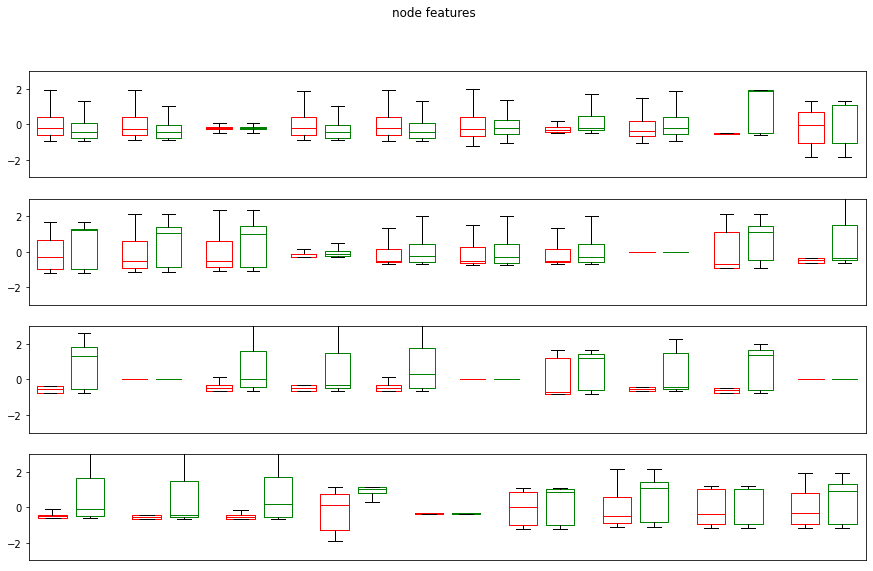

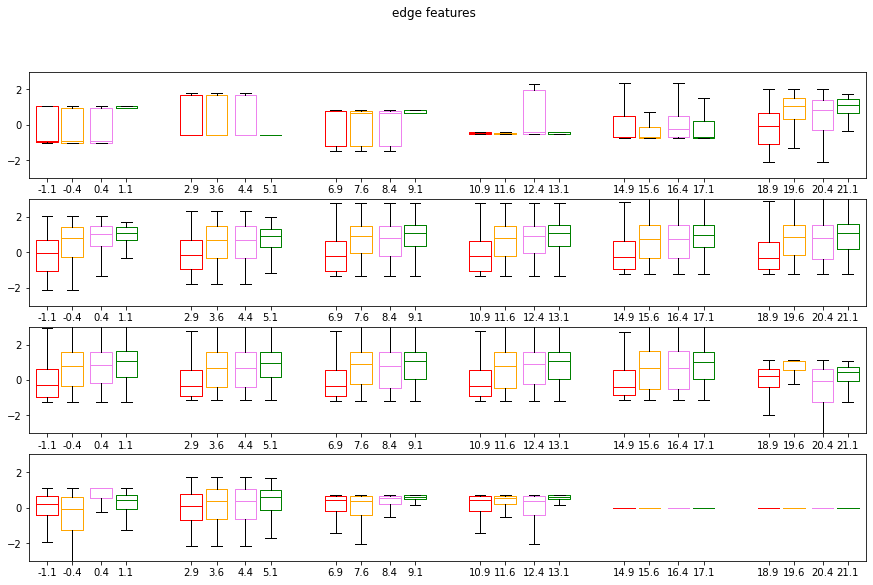

In [59]:
describe_features(graph_list[1])

In [10]:
print(len(input_train), len(input_val))
train_gen = SampleGenerator(False, numb_batches_train)#int(numb_batches * (1-val_size)))
val_gen = SampleGenerator(True, len(input_val))#int(numb_batches * val_size))
set_weight()
gnn = GNN(weight_class_one=weight_class_one)
gnn.compile()
#gnn.compile_nn()

0 242
453 211 4.1469194312796205


In [15]:
train_gen = SampleGenerator(False, numb_batches_train)#int(numb_batches * (1-val_size)))
val_gen = SampleGenerator(True, len(input_val))
input_train[0][0]['input_nodes'].shape

(1, 129, 39)

450/450 [==============================] - 3s 8ms/step - loss: 1.9678 - last_iteration_binary_accuracy: 0.9067 - val_loss: 2.3434 - val_last_iteration_binary_accuracy: 0.9068


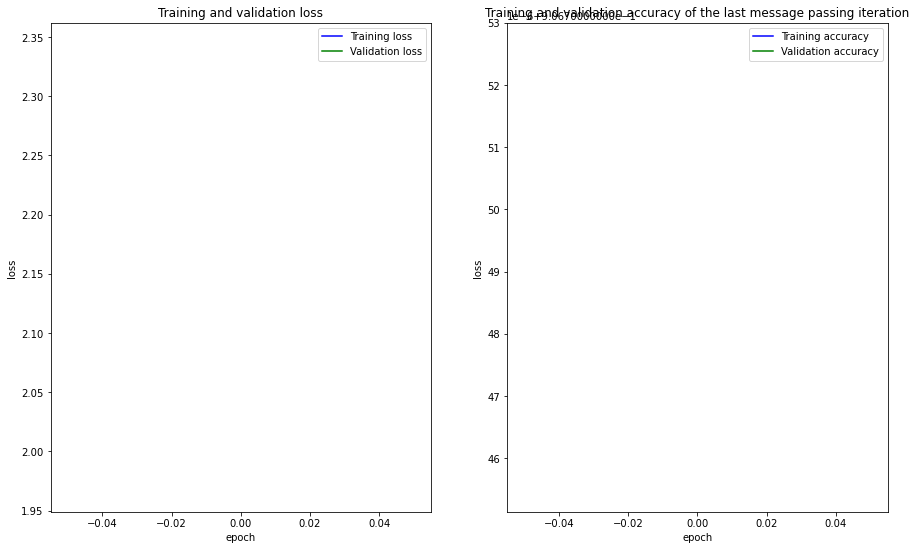

In [16]:
NUM_EPOCHS = 1
#history = gnn.train(train_gen, val_gen, NUM_EPOCHS, out) #!
history = gnn.train(train_gen, val_gen, NUM_EPOCHS, out)


history.history["last_iteration_binary_accuracy"][-1]
_, ax = plt.subplots(ncols = 2, figsize=(15,9))

ax[0].plot(np.arange(NUM_EPOCHS), history.history["loss"], 'b', label = 'Training loss')
ax[0].plot(np.arange(NUM_EPOCHS), history.history["val_loss"], 'g', label = 'Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()

ax[1].plot(np.arange(NUM_EPOCHS), history.history["last_iteration_binary_accuracy"], 'b', label = 'Training accuracy')
ax[1].plot(np.arange(NUM_EPOCHS), history.history["val_last_iteration_binary_accuracy"], 'g', label = 'Validation accuracy')
ax[1].set_title('Training and validation accuracy of the last message passing iteration')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
ax[1].legend()

plt.savefig(out + '.png', dpi=200)

In [17]:
gnn.predict(input_train[0][0])

<tf.Tensor: shape=(1, 1, 128, 1), dtype=float32, numpy=
array([[[[0.92940295],
         [0.8994759 ],
         [0.38474467],
         [0.37424517],
         [0.37337   ],
         [0.4118389 ],
         [0.37628767],
         [0.9365544 ],
         [0.9521784 ],
         [0.8709814 ],
         [0.75693065],
         [0.35947374],
         [0.35977077],
         [0.9446054 ],
         [0.36570472],
         [0.35699788],
         [0.32490587],
         [0.3177012 ],
         [0.9215177 ],
         [0.3659463 ],
         [0.36410996],
         [0.35925737],
         [0.35766825],
         [0.35657015],
         [0.3547984 ],
         [0.35212255],
         [0.35060397],
         [0.4236325 ],
         [0.38263193],
         [0.32317653],
         [0.32193577],
         [0.45540345],
         [0.31804258],
         [0.8501617 ],
         [0.65578103],
         [0.8760769 ],
         [0.3771102 ],
         [0.6415254 ],
         [0.41642126],
         [0.32069746],
         [0.320521  ],
 

In [ ]:
"""input_train = input_train_no_edge
input_val = input_val_no_edge
train_gen = SampleGenerator(False, len(input_train))#int(numb_batches * (1-val_size)))
val_gen = SampleGenerator(True, len(input_val))#int(numb_batches * val_size))

NUM_EPOCHS = 500
history = gnn.train_nn(train_gen, val_gen, NUM_EPOCHS, out) #!
    
history.history["last_iteration_binary_accuracy"][-1]
_, ax = plt.subplots(ncols = 2, figsize=(15,9))

ax[0].plot(np.arange(NUM_EPOCHS), history.history["loss"], 'b', label = 'Training loss')
ax[0].plot(np.arange(NUM_EPOCHS), history.history["val_loss"], 'g', label = 'Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()

ax[1].plot(np.arange(NUM_EPOCHS), history.history["last_iteration_binary_accuracy"], 'b', label = 'Training accuracy')
ax[1].plot(np.arange(NUM_EPOCHS), history.history["val_last_iteration_binary_accuracy"], 'g', label = 'Validation accuracy')
ax[1].set_title('Training and validation accuracy of the last message passing iteration')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
ax[1].legend()

plt.savefig(out + '.png', dpi=200)"""